# 3_3 choose_learning_machine_models with SMOTETomek


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load the file 
data = pd.read_csv('../data/cleaned_data/cleaned_data.csv')
data.head()


,senior_citizen,partner,dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,...,internet_service_Fiber optic,internet_service_No,contract_Month-to-month,contract_One year,contract_Two year,payment_method_Bank transfer (automatic),payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,churn
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0,No
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,No
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,Yes
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,1,0,1,0,0,0,No
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,0,0,1,0,Yes


In [3]:
data.shape

(7032, 26)

### x/y split

In [4]:
#separate the features from the labels
y = data['churn']
X = data.drop(['churn'], axis=1)

In [5]:
# change the type of 'y'
y.dtypes

dtype('O')

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
display(y_train.value_counts())
display(y_test.value_counts())

churn
No     4130
Yes    1495
Name: count, dtype: int64

churn
No     1033
Yes     374
Name: count, dtype: int64

#### It is imbalanced,so it needs up/down sampling or TOMEK

In [8]:
from imblearn.combine import SMOTETomek

# Create SMOTETomek object
smote_tomek = SMOTETomek(random_state=42)

# Apply SMOTETomek to resample the data
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)


In [9]:
X_resampled.shape

(7740, 25)

In [10]:
class_counts = y_resampled.value_counts()
print(class_counts)

churn
Yes    3870
No     3870
Name: count, dtype: int64


In [11]:
# save 
X_resampled.to_csv('../data/x_y_data/SMOTETomek/X_resampled.csv', index=False)
y_resampled.to_csv('../data/x_y_data/SMOTETomek/y_resampled.csv', index=False)
X_test.to_csv('../data/x_y_data/SMOTETomek/X_test.csv', index=False)
y_test.to_csv('../data/x_y_data/SMOTETomek/y_test.csv', index=False)

### Choosing models

In [12]:
X_resampled.shape

(7740, 25)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


models = []
models.append(('LR', LogisticRegression(random_state = 12345)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(random_state = 12345)))
models.append(('GB', GradientBoostingClassifier(random_state = 12345)))

#### Kappa

In [14]:
# evaluate each model in turn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

X_resampled2 = np.ascontiguousarray(X_resampled)
y_resampled2 = np.ascontiguousarray(y_resampled)


kappa_scorer = make_scorer(cohen_kappa_score)

names = []
results = []

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=False)
    cv_results = cross_val_score(model, X_resampled2, y_resampled2, cv=kfold, scoring=kappa_scorer)
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean()} ({cv_results.std()})"
    print(msg)


LR: 0.36589137342699746 (0.246729009075677)
KNN: 0.3593407771632562 (0.24221136823365982)
RF: 0.44665940134619914 (0.2991292342539731)
GB: 0.38910435724544107 (0.26477780080108365)


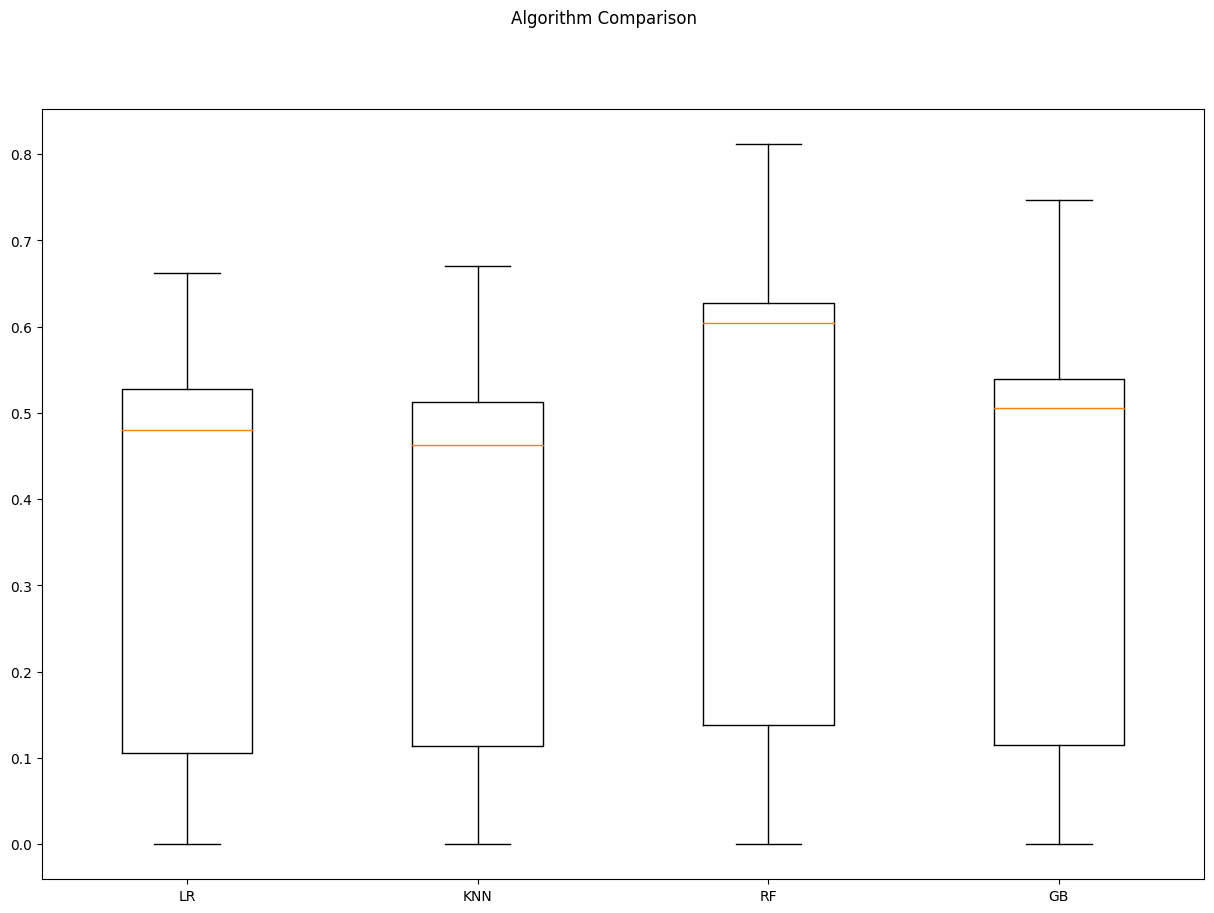

In [15]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [16]:
results_dict = {name: result for name, result in zip(names, results)}

# Create the DataFrame using the dictionary
score = pd.DataFrame(results_dict)

# Print the DataFrame
display(score)

,LR,KNN,RF,GB
0,0.531755,0.502144,0.622807,0.540445
1,0.513973,0.516000,0.628223,0.536810
2,0.489488,0.461325,0.599061,0.503597
3,0.423631,0.464070,0.554191,0.461879
4,0.471332,0.455315,0.609499,0.508952
5,0.567065,0.524668,0.641398,0.592441
6,0.661670,0.669885,0.811415,0.746919
7,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000
